In [914]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
tf.keras.callbacks

In [915]:
#data reading
data = pd.read_csv("./bank-additional.csv", sep=";")

In [916]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [919]:
#one hot encoding of cagtegorical features
onehot_encoder = OneHotEncoder(sparse=False)
cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
onehot = onehot_encoder.fit_transform(data[cols])
onehot = pd.DataFrame(onehot)

In [921]:
#converting output classes into numerical values 0,1,2
labelencoder = LabelEncoder()
labels = labelencoder.fit_transform(data.iloc[:, 20])
labels = pd.DataFrame(labels, columns=['output'])

In [922]:
#all number features, onehot encoded features and label encoded features are concatenated
cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
data = pd.concat([data[cols], onehot, labels], axis=1)

In [924]:
#examples and output classes are separated
X = data.iloc[:,0:63]
Y = data.iloc[:,63]
Y = pd.DataFrame(Y)

In [925]:
#train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [926]:
# sm = SMOTE(random_state=42)
# x_train, y_train = sm.fit_resample(x_train, y_train)
# x_test, y_test = sm.fit_resample(x_test, y_test)

In [927]:
# x_train = pd.DataFrame(x_train)
# y_train = pd.DataFrame(y_train)
# x_test = pd.DataFrame(x_test)
# y_test = pd.DataFrame(y_test)

In [928]:
#one hot encoding
y_train = pd.get_dummies(y_train.iloc[:,0])
y_test = pd.get_dummies(y_test.iloc[:,0])

In [929]:
x_train = x_train.transpose()
y_train = y_train.transpose()
x_test = x_test.transpose()
y_test = y_test.transpose()

In [930]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(63, 3707)
(2, 3707)
(63, 412)
(2, 412)


In [931]:
print (len(data[data["output"] == 0]))
print (len(data[data["output"] == 1]))

3668
451


# tensorflow

In [932]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))

    return X, Y

In [933]:
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [30, 63], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [30, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 30], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer())


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [1029]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                                # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                            # Z3 = np.dot(W3,Z2) + b3
    
    tf.summary.histogram("weights", W1)
    tf.summary.histogram("biases", b1)
    tf.summary.histogram("activations", A1)
    
    return Z3

In [935]:
def compute_cost(Z3, Y):

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [1030]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, print_cost = True):

    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
        
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
#         print (sess.run(parameters))
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0                      # Defines a cost related to an epoch

            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X:X_train, Y:Y_train})
            
            # Print the cost every epoch
            if print_cost == True and epoch % 20 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
                
#         summ = tf.summary.merge_all()
#         sess.run(tf.global_variables_initializer())
            
        predict_op = tf.argmax(Z3,0)
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
#         print (parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(predict_op, tf.argmax(Y,0))
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        tf.summary.scalar("accuracy", accuracy)
        summ = tf.summary.merge_all()
        
        writer = tf.summary.FileWriter("/tmp/1")
        writer.add_graph(sess.graph)
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y:Y_test}))
        
        
        return parameters

Cost after epoch 0: 2.183455
Cost after epoch 20: 1.863928
Cost after epoch 40: 1.550046
Cost after epoch 60: 1.228980
Cost after epoch 80: 0.908986
Cost after epoch 100: 0.663367
Cost after epoch 120: 0.528764
Cost after epoch 140: 0.442196
Cost after epoch 160: 0.380463
Cost after epoch 180: 0.344616
Cost after epoch 200: 0.321324
Cost after epoch 220: 0.298947
Cost after epoch 240: 0.284106
Cost after epoch 260: 0.271704
Cost after epoch 280: 0.259341
Cost after epoch 300: 0.249010
Cost after epoch 320: 0.245853
Cost after epoch 340: 0.241650
Cost after epoch 360: 0.238606
Cost after epoch 380: 0.236282
Cost after epoch 400: 0.237041
Cost after epoch 420: 0.232857
Cost after epoch 440: 0.230593
Cost after epoch 460: 0.229052
Cost after epoch 480: 0.227412
Cost after epoch 500: 0.226021
Cost after epoch 520: 0.224422
Cost after epoch 540: 0.224184
Cost after epoch 560: 0.222248
Cost after epoch 580: 0.220906
Cost after epoch 600: 0.219365
Cost after epoch 620: 0.218419
Cost after epo

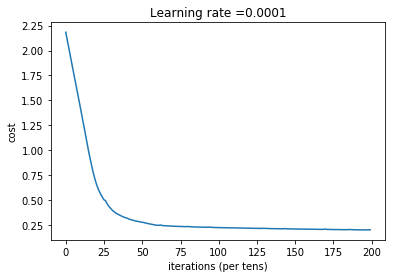

Parameters have been trained!
Train Accuracy: 0.9136768
Test Accuracy: 0.9029126


In [1031]:
parameters = model(x_train, y_train, x_test, y_test)